In [1]:
import os

import pandas as pd
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
df = pd.read_csv('./preprocessed_apartment.csv')
df.head()

,city,district,dong,apartment,m2,price,floor,pre_m2,moving_date,num_people,people_by_m2,price_by_m2,price_by_pre_m2,year,month
0,8,1,1156,1504,196.21,450000.0,13.0,211.23,1976.06,480.0,120.0,7582.0,7043.0,2018,12
1,8,1,1706,4942,202.58,450000.0,5.0,252.31,2010.07,19.0,1.0,7343.0,5896.0,2018,12
2,8,1,1156,9746,139.83,320000.0,7.0,165.29,1982.04,1924.0,168.0,7565.0,6400.0,2018,12
3,8,1,393,15322,191.04,315000.0,2.0,219.22,1983.12,1204.0,84.0,5451.0,4750.0,2018,12
4,8,1,1156,1509,144.20,304000.0,10.0,158.68,1979.05,560.0,168.0,6969.0,6333.0,2018,12


In [3]:
df.shape

(6174900, 15)

In [4]:
y = df['price']
del df['price']

In [5]:
x_train, x_test,y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=0)

In [6]:
lightgbm = lgb.LGBMRegressor(random_state=0)

In [7]:
kfold = KFold(n_splits=5, random_state=0).get_n_splits(x_train.values)
cross_val_score(lightgbm, x_train.values, y_train)

C:\ProgramData\Anaconda3\envs\p36\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


array([0.99727589, 0.99734241, 0.99746746])

In [8]:
lightgbm.fit(x_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [9]:
modelPred = lightgbm.predict(x_test)
RMSE = sqrt(mean_squared_error(y_test, modelPred))
RMSE

1162.6522626090643

In [10]:
Y_prediction = modelPred.flatten()
for i in range(10):
    label = y_test.values[i]
    prediction = Y_prediction[i]
    print("실제가격: {:.3f}, 예상가격: {:.3f}".format(label, prediction))

실제가격: 25000.000, 예상가격: 24647.146
실제가격: 20900.000, 예상가격: 20523.162
실제가격: 35700.000, 예상가격: 36001.417
실제가격: 29250.000, 예상가격: 29769.758
실제가격: 5800.000, 예상가격: 5868.432
실제가격: 9500.000, 예상가격: 9083.648
실제가격: 15400.000, 예상가격: 15092.925
실제가격: 6300.000, 예상가격: 6388.948
실제가격: 20100.000, 예상가격: 20254.150
실제가격: 41500.000, 예상가격: 40657.368


In [11]:
model = Sequential()
model.add(Dense(240, input_dim=14, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
model.compile(loss='mean_squared_error',
             optimizer='adam',
             metrics=['accuracy'])

In [13]:
# 모델 저장 폴더 설정
MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)
    
# 모델 저장 조건 설정
modelpath = MODEL_DIR + '{epoch:02d}-{val_loss:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
# loss는 train loss고 val_loss는 validation loss임 / acc도 마찬가지

In [14]:
history = model.fit(x_train, y_train, validation_split=0.4, epochs=10, batch_size=10000, callbacks=[checkpointer])

Instructions for updating:
Use tf.cast instead.
Train on 2593458 samples, validate on 1728972 samples
Epoch 1/10
2593458/2593458 [==============================] - 8s 3us/step - loss: 260355050.4690 - acc: 6.5164e-05 - val_loss: 91121849.9652 - val_acc: 1.4112e-04

Epoch 00001: val_loss improved from inf to 91121849.96519, saving model to ./model/01-91121849.9652.hdf5
Epoch 2/10
2593458/2593458 [==============================] - 5s 2us/step - loss: 54216898.5247 - acc: 2.2865e-04 - val_loss: 25972974.2981 - val_acc: 3.1175e-04

Epoch 00002: val_loss improved from 91121849.96519 to 25972974.29808, saving model to ./model/02-25972974.2981.hdf5
Epoch 3/10
2593458/2593458 [==============================] - 6s 2us/step - loss: 17400567.0341 - acc: 3.0924e-04 - val_loss: 9860683.4462 - val_acc: 2.7878e-04

Epoch 00003: val_loss improved from 25972974.29808 to 9860683.44621, saving model to ./model/03-9860683.4462.hdf5
Epoch 4/10
2593458/2593458 [==============================] - 6s 2us/step 

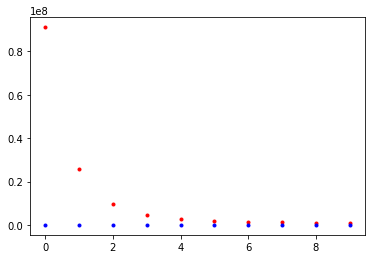

In [15]:
# y_vloss에 테스트셋으로 실험 결과의 오차 값을 저장
y_vloss = history.history['val_loss']

# y_acc에 학습셋으로 측정한 정확도의 값을 저장
y_acc = history.history['acc']

# x값을 지정하고 정확도를 파랑색으로, 오차를 빨강색으로 표시
x_len = np.arange(len(y_acc))
plt.plot(x_len, y_vloss, "o", c="red", markersize=3)
plt.plot(x_len, y_acc, "o", c="blue", markersize=3)

plt.show()

In [16]:
modelPred = model.predict(x_test)
RMSE = sqrt(mean_squared_error(y_test, modelPred))
RMSE

810.2484778411637

In [17]:
Y_prediction = modelPred.flatten()
for i in range(10):
    label = y_test.values[i]
    prediction = Y_prediction[i]
    print("실제가격: {:.3f}, 예상가격: {:.3f}".format(label, prediction))

실제가격: 25000.000, 예상가격: 24969.158
실제가격: 20900.000, 예상가격: 20789.713
실제가격: 35700.000, 예상가격: 34585.844
실제가격: 29250.000, 예상가격: 29009.115
실제가격: 5800.000, 예상가격: 5959.814
실제가격: 9500.000, 예상가격: 9341.768
실제가격: 15400.000, 예상가격: 15007.945
실제가격: 6300.000, 예상가격: 6298.426
실제가격: 20100.000, 예상가격: 19998.412
실제가격: 41500.000, 예상가격: 41162.742
